In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

In [39]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [40]:
train.isna().sum().sum()

0

In [41]:
train.columns

Index(['id', 'Overall Qual', 'Gr Liv Area', 'Exter Qual', 'Garage Cars',
       'Garage Area', 'Kitchen Qual', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Full Bath', 'Year Built', 'Year Remod/Add',
       'Garage Yr Blt', 'target'],
      dtype='object')

In [42]:
numerical = train.columns[train.dtypes != 'object']
numerical

Index(['id', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt', 'target'],
      dtype='object')

In [43]:
features = numerical[1:-1]
features

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt'],
      dtype='object')

In [44]:
def plot_features(df, name, outlier_dict = None, is_outlier = False):
  plt.figure(figsize=(20,15))
  plt.suptitle(name,fontsize = 30, y = 1)
  target = train['target']
  for i in range(len(features)):
    plt.subplot(4,3,i+1)
    plt.xlabel(features[i])
    plt.ylabel('target')
    plt.plot(df[features[i]], target, linestyle = 'none', marker = 'o')
    if is_outlier:
      outlier = outlier_dict[features[i]]
      plt.plot(df[features[i]].iloc[outlier], target[outlier], linestyle='none', marker='o',c='r',label='outlier')

    plt.tight_layout() #레이아웃을 바로 잡아준다.


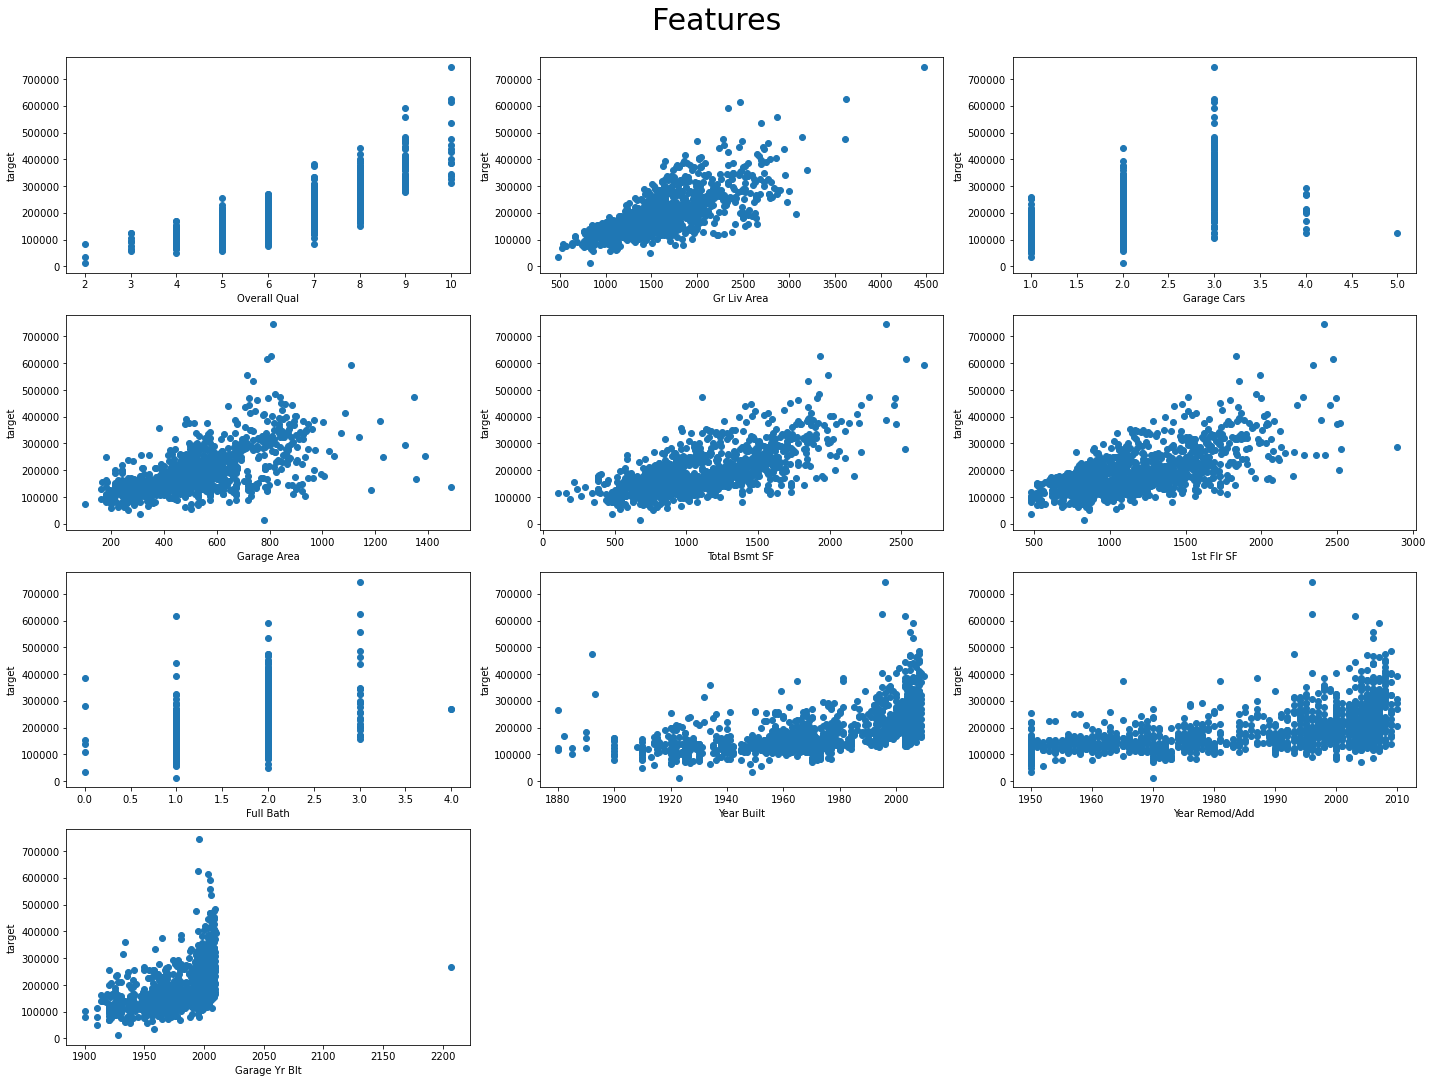

In [45]:
plot_features(train,'Features')

In [46]:
def get_IQR(df):
    #use IQR
    from collections import defaultdict
    quantile_25 = df.loc[::,features].apply(lambda x: np.quantile(x, 0.25))
    quantile_75 = df.loc[::,features].apply(lambda x: np.quantile(x, 0.75))
    iqr = quantile_75 - quantile_25
    lower = quantile_25 - iqr * 2.0
    upper = quantile_75 + iqr * 2.0
    out_indexes = np.where((df[features] <= lower) | (df[features] >= upper))
    outlier_dict = defaultdict(list)
    for r,c in (zip(*out_indexes)):
        outlier_dict[features[c]].append(r)
    return outlier_dict

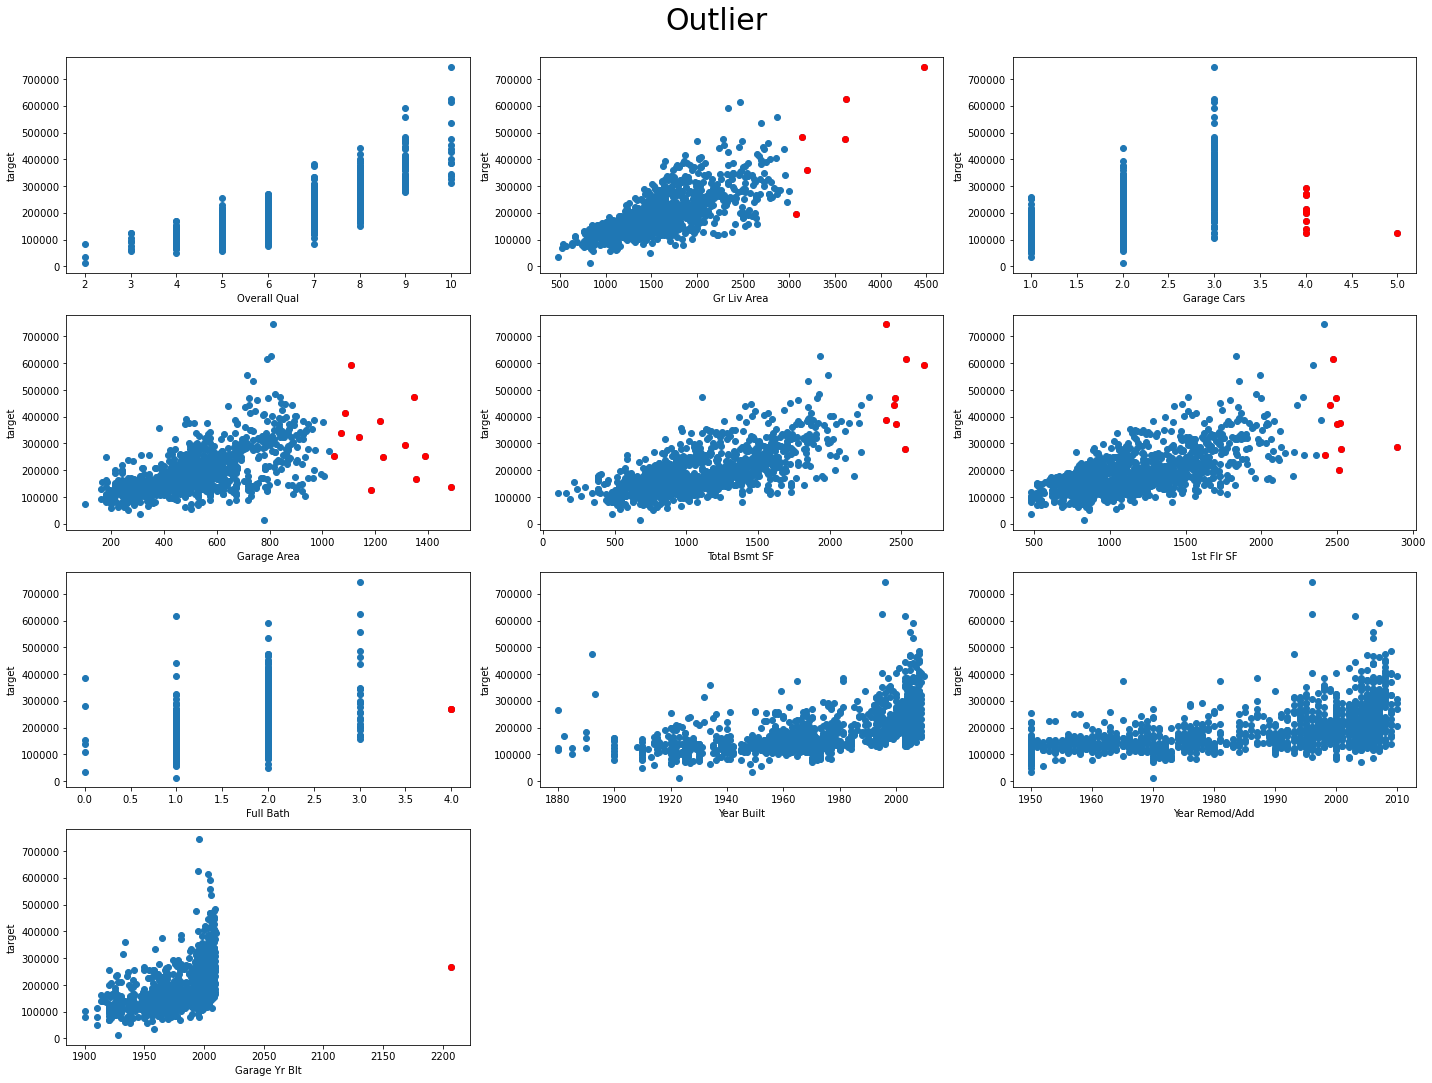

In [47]:
outlier_dict = get_IQR(train)
plot_features(train,"Outlier",outlier_dict, is_outlier=True)

We can't remove data in the reason they are huge or small. Small or huge value also could be valid data. For example "Over qual" feature has lots of outliers but show stable patterns with target. So we should not remove this kind of data as these data's have valuable inform to improve machine. So we'll remove real outlier that doesn't have pattern and can't be explained. 

In [37]:
#remove outlier
#remove Garage Yr Blt, Full bath,1st Flr SF
for i in ['Garage Yr Blt','Full Bath']:
    train.iloc[outlier_dict[i]] = None
train.isna().sum()

id                3
Overall Qual      3
Gr Liv Area       3
Exter Qual        3
Garage Cars       3
Garage Area       3
Kitchen Qual      3
Total Bsmt SF     3
1st Flr SF        3
Bsmt Qual         3
Full Bath         3
Year Built        3
Year Remod/Add    3
Garage Yr Blt     3
target            3
dtype: int64

In [48]:
#결측치가 삭제 된 것을 확인 할 수 있다.
before = len(train)
train.dropna(inplace=True)
print(f"remove cnt: {before - len(train)}")

remove cnt: 0


Text(0.5, 1.0, 'correlation between features')

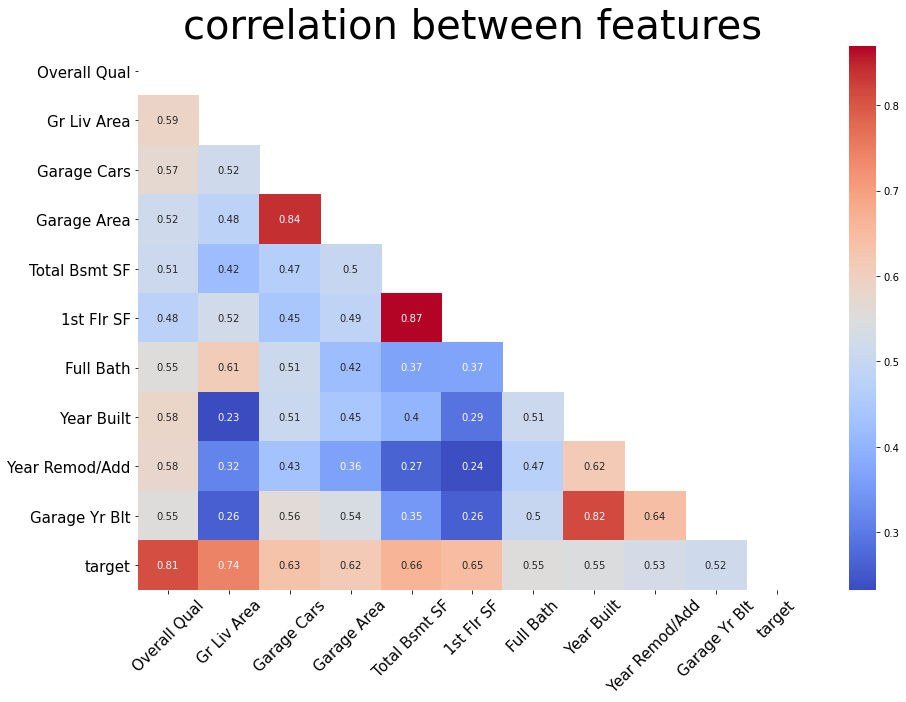

In [50]:
plt.figure(figsize=(15,10))
heat_table = train[numerical[1:]].corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)

(Garage Area, Garage Cars), (Year Built, Garage Yr Blt),(1st Flr SF, Total Bsmt SF) has high correlation. It might be better to remove some features.


In [68]:
remove_columns = ['Garage Cars','Garage Yr Blt']
removed_train = train.drop(remove_columns,axis=1)
removed_train

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,target
0,1,10,2392,4,968,4,2392,2392,4,2,2003,2003,386250
1,2,7,1352,3,466,3,1352,1352,4,2,2006,2007,194000
2,3,5,900,1,288,1,864,900,1,1,1967,1967,123000
3,4,5,1174,1,576,3,680,680,1,1,1900,2006,135000
4,5,7,1958,3,936,3,1026,1026,3,2,2005,2005,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,1346,6,1756,3,422,1,872,888,4,2,1996,1997,204000
1346,1347,9,2748,3,850,4,1850,1850,4,2,2006,2006,390000
1347,1348,5,1214,1,318,1,1214,1214,1,2,1967,1967,143000
1348,1349,5,894,1,440,1,864,894,3,1,1974,1974,131000


Now we are gonna check the solutions by solving just simple normal equations.

In [52]:
def normal_equation(df,features):
    matrix = df[features].values #정규방정식을 활용, target은 포함하지 않아야 한다.
    regulization = np.eye(matrix.shape[1])
    regulization[0][0] = 0 #bias는 정규화를 진행하지 않는다.
    left_equation = (matrix.T).dot(matrix) + regulization
    right_equation = (matrix.T).dot(df['target'])
    theta = np.linalg.solve(left_equation, right_equation)
    return theta

In [53]:
def visualize(pred, label, name):
  plt.figure(figsize = (12,8))
  plt.plot(range(len(label)), pred, label = 'pred',linestyle='none',marker='o')
  plt.plot(range(len(label)), label ,label = 'target',linestyle='none',marker='o')
  mse = np.mean((label - pred) ** 2)
  plt.suptitle(f'{name}',fontsize=20)
  plt.title(f'MSE is {mse:.1f}')
  plt.legend()

In [72]:
theta = normal_equation(train,features)
print(f'train : {theta}')

train : [ 2.52212632e+04  5.76515095e+01  5.25861253e+03  3.90258154e+01
  5.13404758e+01 -3.01200919e+00 -7.84158991e+03  2.59246203e+02
 -6.57635354e+01 -2.56549674e+02]


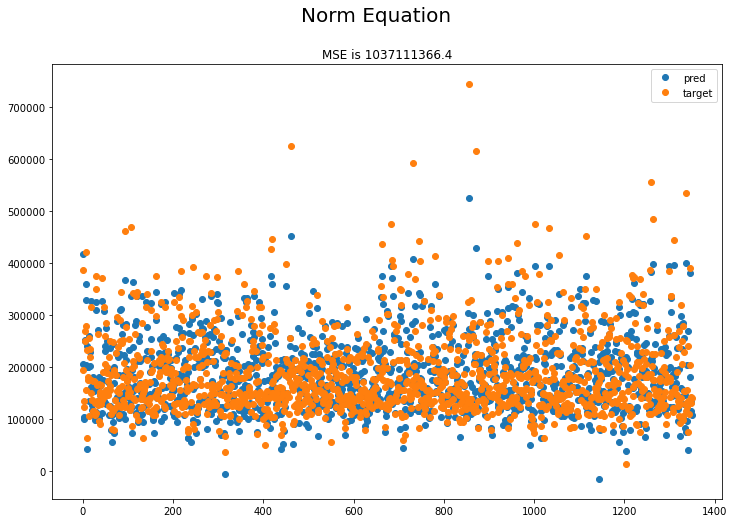

In [73]:
hypo = train[features].dot(theta).values
visualize(hypo,train['target'],'Norm Equation')

In [69]:
r_features = [c for c in features if c not in remove_columns]
r_theta = normal_equation(removed_train, r_features)
print(f'removed : {r_theta}')

removed : [ 2.59508394e+04  5.80726246e+01  4.49101851e+01  5.19289993e+01
 -2.78206734e+00 -7.02117368e+03  1.15959107e+02 -1.79277267e+02]


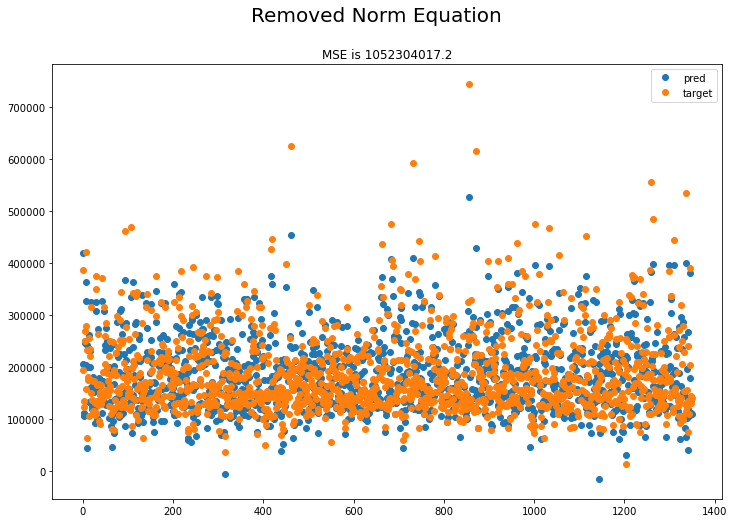

In [70]:
r_hypo = removed_train[r_features].dot(r_theta).values
visualize(r_hypo,train['target'],'Removed Norm Equation')

Regardless of feature extraction two solutions seemed to be overfitted. It's time to use regulator to prevent overfit and improve performance in test data. To use regulater will gonna construct Ridge model which use L2 norm to regularize.

Ridge model which has fewer feature seems to prevent better than model use whole features. So make model in fewer features might be better in this problem. And for now we are about to use categorical data

Use label Encoder to make machine understands text data

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin
class CategoricalTransformer(BaseEstimator,TransformerMixin):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
        return
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = [c for c in X.columns[X.dtypes == 'object']]
        for c in features:
            X[c] = X[c].apply(lambda x: ['Po','TA','Fa','Gd','Ex'].index(x))
        return X

In [60]:
total_features = train.columns[1:-1]
cat = CategoricalTransformer(train)
X_train, X_eval, y_train, y_eval = train_test_split(cat.transform(train)[total_features],train['target'], train_size = 0.7, test_size = 0.3, random_state = 4)

In [61]:
regulator = Ridge(alpha=1,solver="cholesky",
                random_state=42)
model = Pipeline([
    ("label_encoder",CategoricalTransformer(train)),
    ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
    ("std_scaler",StandardScaler()),
    ("regul_reg",regulator)
                ])
                
def fit_model(X,y):
    model.fit(X, y)
    pred = model.predict(X)
    return pred

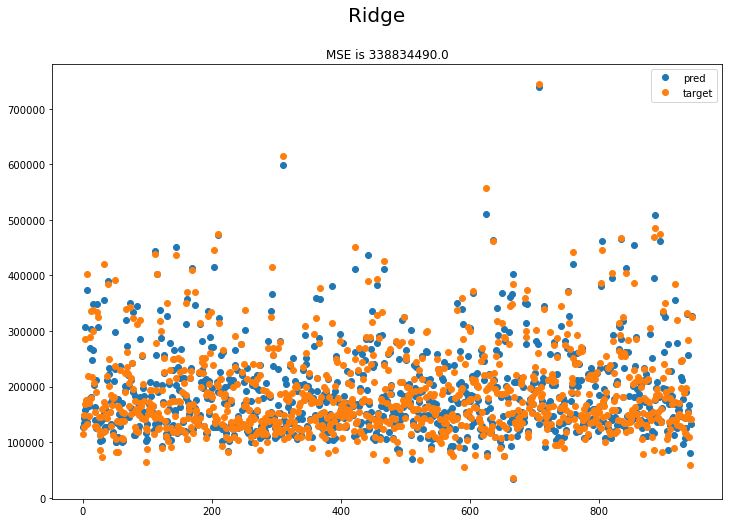

In [74]:
visualize(fit_model(X_train, y_train), y_train, 'Ridge')

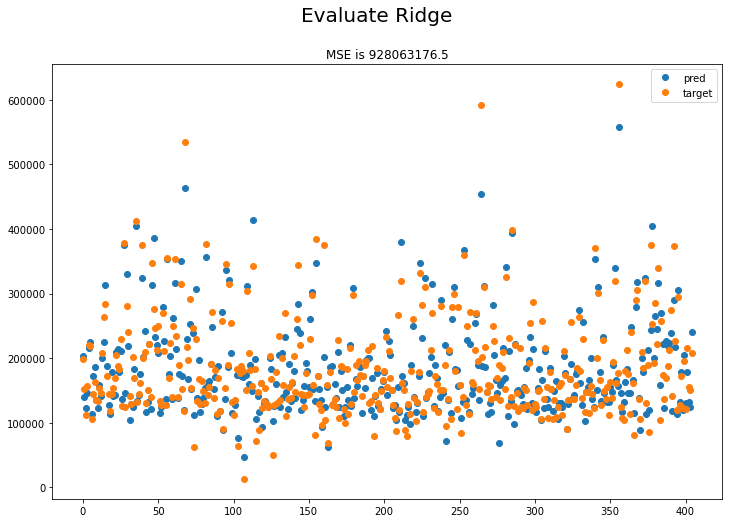

In [75]:
visualize(model.predict(X_eval), y_eval, 'Evaluate Ridge')

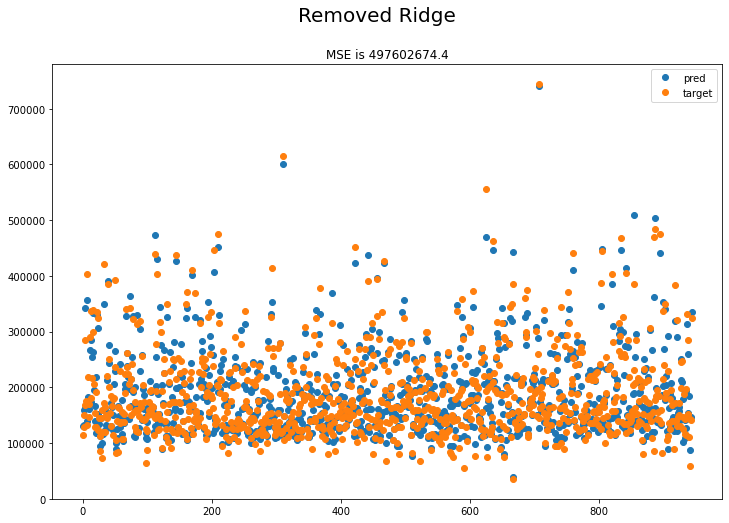

In [76]:
visualize(fit_model(X_train[r_features], y_train), y_train, 'Removed Ridge')

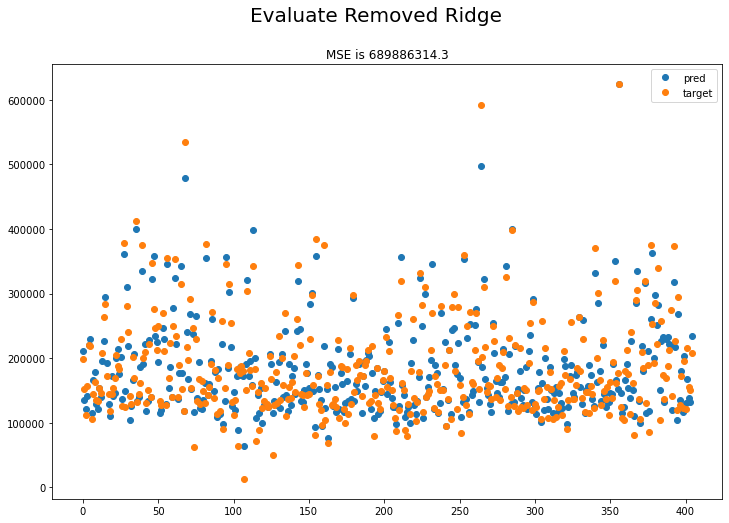

In [77]:
visualize(model.predict(X_eval[r_features]), y_eval, 'Evaluate Removed Ridge')

정규화 항을 튜닝해보자. 

In [81]:
for i in [1000,300,100,30,10,1]:
  regulator = Ridge(alpha=i,solver="cholesky",
                  random_state=42)
  model.set_params(regul_reg__alpha=i)
  model.fit(X_train[r_features], y_train)
  pred = model.predict(X_eval[r_features])
  mse = ((y_eval - pred) ** 2).mean()
  print(f'mse: {mse}, alpha: {i}')

mse: 748922838.7735909, alpha: 1000
mse: 711959947.9006848, alpha: 300
mse: 694189282.2454253, alpha: 100
mse: 685821376.5819339, alpha: 30
mse: 681346371.2130548, alpha: 10
mse: 677168636.7864627, alpha: 1


In [86]:
#final model
regulator = Ridge(alpha = 100,solver = "cholesky",
                random_state = 42)
model = Pipeline([("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
                ("std_scaler",StandardScaler()),
                ("regul_reg",regulator)
                ])
model.fit(X_train,y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('std_scaler', StandardScaler()),
                ('regul_reg',
                 Ridge(alpha=100, random_state=42, solver='cholesky'))])

In [83]:
test_X = cat.transform(test)
res = pd.DataFrame({'id':test['id'], 'target':model.predict(test_X[r_features])})
res


,id,target
0,1,332623.333514
1,2,129001.757232
2,3,176751.062198
3,4,250902.875100
4,5,139101.454636
...,...,...
1345,1346,320559.205387
1346,1347,116227.619791
1347,1348,91579.014597
1348,1349,178778.113273


In [88]:
res.to_csv('res.csv',index=None)